# Data Exploration and Visualization - Taxi Data

# Overview and Motivation:

Our goal is to accurately estimate how much cash tips go unreported each year in New York City’s Taxi system. On that vein, our secondary goal is to understand what factors related to a trip, such as time of day or location, might influence the tip amount.

#Related Work: 

- http://hafen.github.io/taxi/
- http://toddwschneider.com/posts/analyzing-1-1-billion-nyc-taxi-and-uber-trips-with-a-vengeance/
- http://iquantny.tumblr.com/post/107245431809/how-software-in-half-of-nyc-cabs-generates-52
- http://fivethirtyeight.com/features/uber-is-taking-millions-of-manhattan-rides-away-from-taxis/

# Exploratory Data Analysis: 

We first plotted basic graphs to understand how correlations among different trip variables. We then decided to use more advanced methods to gain a deeper understanding of our data. We used linear regression, KNN classifier, KNN regression, and neural network classifiers. We plotted our data in different forms (location maps, line graphs, bar graphs, density plots, and histograms). We visualized our data with a lot of histograms. We used the linear regression to jumpstart our statistical analysis. We moved on to kNN thinking location data might be helpful for tip prediction, but also looked at other features based on the KDE plots we made. We chose to try NN, because we had only mild success with the kNN, so we looked to a more advanced method.

## Libraries

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap

import os

%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import seaborn as sns
sns.set_style("darkgrid", {'axes.grid' : False})
sns.set_context("poster")

/Users/stefan/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Relevant Links

* Data (Yellow Cab, 2013): http://www.andresmh.com/nyctaxitrips/

* Data (Yellow cab, June 2015): http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml

* *Incredible* visualization: http://nyctaxi.herokuapp.com/

**Privacy Concerns**

* Privacy concerns with the dataset: http://research.neustar.biz/2014/09/15/riding-with-the-stars-passenger-privacy-in-the-nyc-taxicab-dataset/

* Locating Muslim cab drivers: http://mashable.com/2015/01/28/redditor-muslim-cab-drivers/#PJCrpyV6tPqY

**Uber Disruption**

* October 13, 2015: http://fivethirtyeight.com/features/uber-is-taking-millions-of-manhattan-rides-away-from-taxis/

* August 10, 2015: http://fivethirtyeight.com/features/uber-is-serving-new-yorks-outer-boroughs-more-than-taxis-are/

## Brainstorming

With the Uber data, we could look at change in pickups between taxis and Uber. 538 already did this (see 10/13/15 article).

So taxi cab drivers *are* full-time employees. Cite that. However, Uber drivers are treated as independent contractors. This changes their compensation package, tax structure, and most importantly benefits (i.e. no health care).

## Import Data

For this project, we use publically available NYC Yellow Taxi Cab data from June 2013. The entire dataset is too large to work with, so we obtained a subsample of the dataset. The subsample comes as two files: "fare" data (1.3 GB) and "trip" data (2.3 GB). We import both files and merge them to obtain complete information about each ride. 

In [2]:
# Because the dataset is too large, we only pull information for the first 1 million trips
ssize = 1000000
df2013trip = pd.read_csv('raw_data/trip_data_1.csv', nrows=ssize)
df2013fare = pd.read_csv('raw_data/trip_fare_1.csv', nrows=ssize)

In [3]:
#dataset containing trip information
df2013trip.head()

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,89D227B655E5C82AECF13C3F540D4CF4,BA96DE419E711691B9445D6A6307C170,CMT,1,N,2013-01-01 15:11:48,2013-01-01 15:18:10,4,382,1.0,-73.978165,40.757977,-73.989838,40.751171
1,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-06 00:18:35,2013-01-06 00:22:54,1,259,1.5,-74.006683,40.731781,-73.994499,40.750660
2,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-05 18:49:41,2013-01-05 18:54:23,1,282,1.1,-74.004707,40.737770,-74.009834,40.726002
3,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:54:15,2013-01-07 23:58:20,2,244,0.7,-73.974602,40.759945,-73.984734,40.759388
4,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:25:03,2013-01-07 23:34:24,1,560,2.1,-73.976250,40.748528,-74.002586,40.747868


In [4]:
#dataset containing fare information
df2013fare.head()

,medallion,hack_license,vendor_id,pickup_datetime,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,89D227B655E5C82AECF13C3F540D4CF4,BA96DE419E711691B9445D6A6307C170,CMT,2013-01-01 15:11:48,CSH,6.5,0.0,0.5,0,0,7.0
1,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,2013-01-06 00:18:35,CSH,6.0,0.5,0.5,0,0,7.0
2,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,2013-01-05 18:49:41,CSH,5.5,1.0,0.5,0,0,7.0
3,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,2013-01-07 23:54:15,CSH,5.0,0.5,0.5,0,0,6.0
4,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,2013-01-07 23:25:03,CSH,9.5,0.5,0.5,0,0,10.5


### Data cleaning

First, we merge and clean the datasets. The column names are slightly different. And information about the trip and fare are split into separate data chunks. They can be merged into a single dataframe based on columns like medallion - a hash value that represents a unique taxi driver.

See the difference in column names?

In [5]:
print df2013trip.columns
print 
print df2013fare.columns

Index([u'medallion', u'hack_license', u'vendor_id', u'rate_code', u'store_and_fwd_flag', u'pickup_datetime', u'dropoff_datetime', u'passenger_count', u'trip_time_in_secs', u'trip_distance', u'pickup_longitude', u'pickup_latitude', u'dropoff_longitude', u'dropoff_latitude'], dtype='object')

Index([u'medallion', u' hack_license', u' vendor_id', u' pickup_datetime', u' payment_type', u' fare_amount', u' surcharge', u' mta_tax', u' tip_amount', u' tolls_amount', u' total_amount'], dtype='object')


In [6]:
#rename the columns to elminate the leading white space 
df2013fare.rename(columns={
        ' hack_license' : 'hack_license',
        ' vendor_id' : 'vendor_id',
        ' pickup_datetime' : 'pickup_datetime',
        ' payment_type' : 'payment_type',
        ' fare_amount' : 'fare_amount',
        ' surcharge' : 'surcharge',
        ' mta_tax' : 'mta_tax',
        ' tip_amount' : 'tip_amount',
        ' tolls_amount' : 'tolls_amount',
        ' total_amount' : 'total_amount'
    }, inplace=True)

Now we merge our two data sets containing trip and fare information for the same cab trips into a single dataframe called `merged2013df`. 

In [7]:
#merge the two datasets
merged2013dffull = pd.merge(df2013trip, df2013fare, on=['medallion', 'hack_license', 'vendor_id', 'pickup_datetime'], how='inner')
merged2013dffull.head()

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,89D227B655E5C82AECF13C3F540D4CF4,BA96DE419E711691B9445D6A6307C170,CMT,1,N,2013-01-01 15:11:48,2013-01-01 15:18:10,4,382,1.0,-73.978165,40.757977,-73.989838,40.751171,CSH,6.5,0.0,0.5,0,0,7.0
1,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-06 00:18:35,2013-01-06 00:22:54,1,259,1.5,-74.006683,40.731781,-73.994499,40.750660,CSH,6.0,0.5,0.5,0,0,7.0
2,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-05 18:49:41,2013-01-05 18:54:23,1,282,1.1,-74.004707,40.737770,-74.009834,40.726002,CSH,5.5,1.0,0.5,0,0,7.0
3,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:54:15,2013-01-07 23:58:20,2,244,0.7,-73.974602,40.759945,-73.984734,40.759388,CSH,5.0,0.5,0.5,0,0,6.0
4,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:25:03,2013-01-07 23:34:24,1,560,2.1,-73.976250,40.748528,-74.002586,40.747868,CSH,9.5,0.5,0.5,0,0,10.5


Now let's clean our tip data. The first thing we do is add a column called `tip_amount_normalized` that calculates the tip as a percentage of the fare amount. 

In [8]:
merged2013dffull['tip_amount_normalized'] = merged2013dffull.tip_amount/merged2013dffull.fare_amount
merged2013dffull.shape

(1000000, 22)

Next, we eliminate the row with missing or inaccurate latitude or longitude information. Some entries have latitudes and longitudes that don't make sense, such as the middle of the ocean. These errors will skew our analysis so we remove those entries as well. 

In [9]:
merged2013dffull = merged2013dffull[merged2013dffull.pickup_latitude.between(40.65,40.85)]
merged2013dffull = merged2013dffull[merged2013dffull.pickup_longitude.between(-74.025,-73.85)]
merged2013dffull = merged2013dffull[merged2013dffull.dropoff_latitude.between(40.65,40.85)]
merged2013dffull = merged2013dffull[merged2013dffull.dropoff_longitude.between(-74.025,-73.85)]
merged2013dffull = merged2013dffull.reset_index(drop=True)
merged2013dffull.shape

(938710, 22)

# Where are people going?

We want to look at where people are going. Let's create index variables to represent the rate codes

In [10]:
#Add column that replaces rate codes with string names

rate_codes = {
    1: 'Standard Rate',
    2: 'JFK',
    3: 'Newark',
    4: 'Nassau or Westchester',
    5: 'Negotiated fare',
    6: 'Group Ride'
}

merged2013dffull['rate_code_name'] = merged2013dffull['rate_code'].map(lambda x: rate_codes[x])

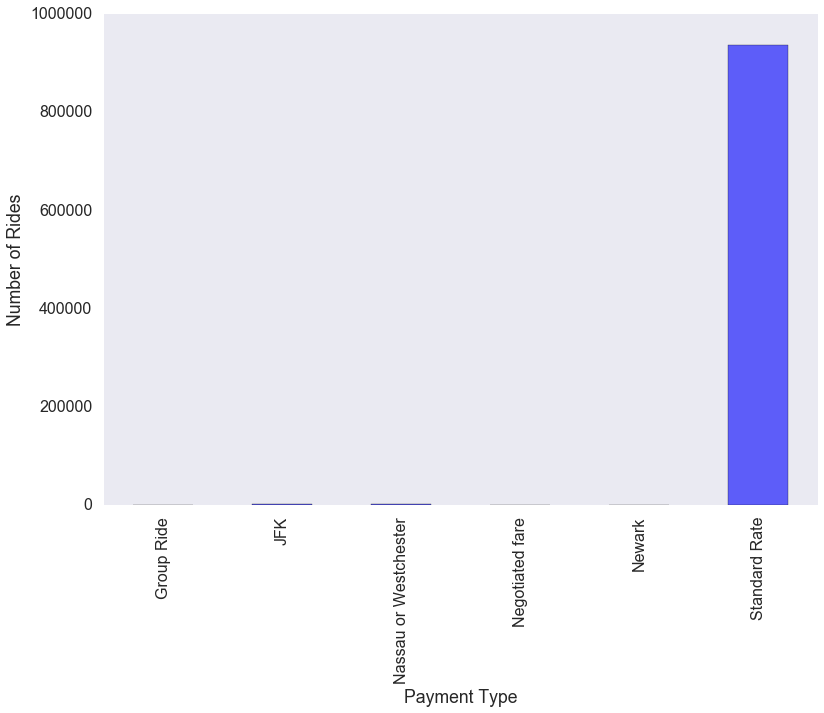

In [11]:
#Now let's plot the different Rate codes to see where people are going
ratecode_tip = merged2013dffull.groupby(['rate_code_name'])['medallion'].count()
ratecode_tip.head()
ax = ratecode_tip.plot(kind='bar', x='rate_code_name', y='medallion', alpha=.6)
ax.set_xlabel("Payment Type")
ax.set_ylabel("Number of Rides")
ax.grid(False)

For our regression, we only care about standard rate fares, because they make up the vast majority of New York taxi trips, and because they are more correlated with tip amount & distance

In [12]:
#Only include standard rate in our regression
merged2013dffull = merged2013dffull[merged2013dffull['rate_code'] == 1]

Some trip entries have distance =0, which means they are incomplete or never happened. Let's remove these so our entries all represent real trips

In [13]:
#Remove incomplete trips
merged2013dffull = merged2013dffull[merged2013dffull.trip_distance > 0]

Next, we want to remove payment types that don't help our data analysis. What payment methods do passengers use?

In [14]:
#First, let's get a list of all the unique payment types
payment_types = list(merged2013dffull.payment_type.unique())
payment_types

['CSH', 'DIS', 'CRD', 'UNK']

The different payment methods are Cash, Disputed, No Charge, Credit Card, and Unknown. How many trips are made using each payment type? 

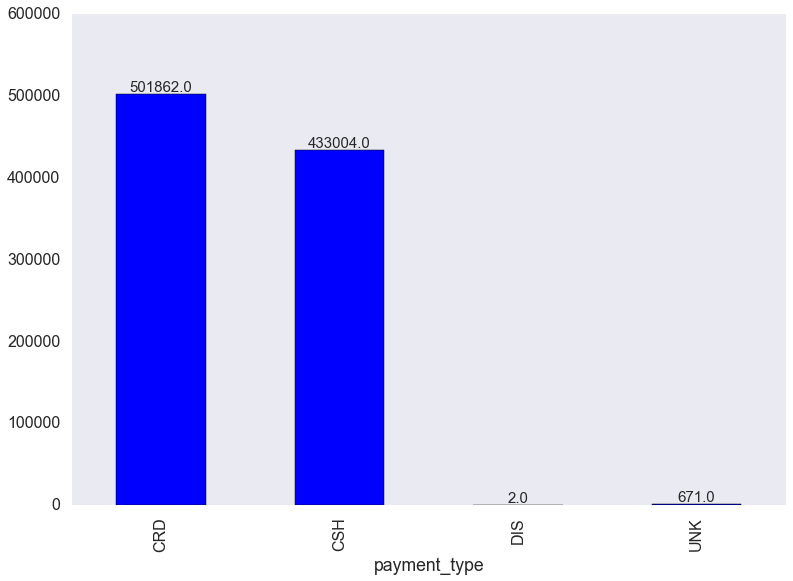

In [15]:
#Calculate how many trips are made using each payment type
payment_types = merged2013dffull.groupby("payment_type")['medallion'].count()
ax = payment_types.plot(kind="bar")

#add text values on top of the bars
bars = ax.patches

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 200, height, ha='center', va='bottom', fontsize=15)
plt.savefig('images/payment_types')

We only care about analyzing Cash and Credit, so we can remove the others. Since the others make up < 1% of our dataset, removing them will not have a significant impact on our analysis.

In [16]:
# Remove rare payment types
merged2013dffull = merged2013dffull[merged2013dffull.payment_type != 'UNK']
merged2013dffull = merged2013dffull[merged2013dffull.payment_type != 'DIS']
merged2013dffull = merged2013dffull[merged2013dffull.payment_type != 'NOC']
merged2013dffull = merged2013dffull.reset_index(drop=True)
print merged2013dffull.shape

(934866, 23)


Now let's compare the  number of passengers paying cash vs. credit

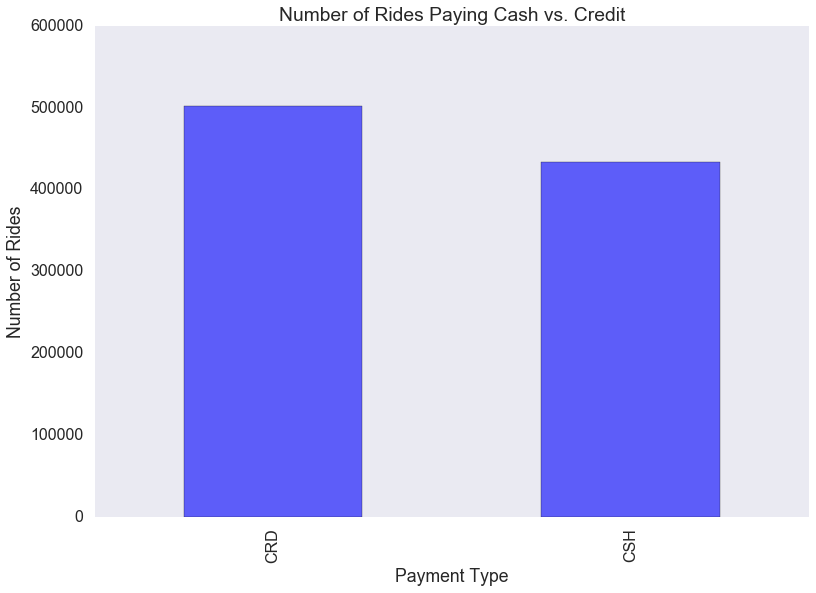

In [17]:
payment_counts = merged2013dffull.groupby(['payment_type'])['medallion'].count()
ax = payment_counts.plot(kind='bar', x='payment_type', y='medallion', alpha=.6)
ax.set_xlabel("Payment Type")
ax.set_ylabel("Number of Rides")
ax.grid(False)
ax.set_title('Number of Rides Paying Cash vs. Credit')
payment_counts.head()
plt.savefig('images/cash_vs_credit')

In [18]:
total_trips = float(merged2013dffull.shape[0])
cash_trips = float(payment_counts['CSH']/total_trips*100)
cc_trips = float(payment_counts['CRD']/total_trips*100)
print "%.2f" % cash_trips, "% of trips pay with cash"
print "%.2f" % cc_trips, "% of trips pay with credit cards"

46.32 % of trips pay with cash
53.68 % of trips pay with credit cards


The number of riders who pay with credit card is slightly higher than the number of riders who pay with cash.

#### Pickup and Dropoff Times
Now we want to look at pickup and dropoff times. In order to do this, we need to convert our times to date objects.

In [19]:
#convert pickup and dropoff to date objects
merged2013dffull['pickup_datetime'] = pd.to_datetime(merged2013dffull['pickup_datetime'])
merged2013dffull['dropoff_datetime'] = pd.to_datetime(merged2013dffull['dropoff_datetime'])
merged2013dffull.shape

(934866, 23)

We also add a column to convert our pickup times to number of seconds since midnight.

In [20]:
def seconds_since_midnight(d):
    ddelta = (d - d.replace(hour=0, minute=0, second=0, microsecond=0))
    return ddelta.total_seconds()

merged2013dffull['secs_since_midnight'] = merged2013dffull.pickup_datetime.apply(seconds_since_midnight)
merged2013dffull = merged2013dffull[merged2013dffull['trip_time_in_secs'] > 0]
merged2013dffull['hours_since_midnight'] = np.floor(merged2013dffull['secs_since_midnight']/3600).apply(lambda x: int(x))

#### Filter out Cash transactions

In [21]:
#Make a copy of cash transactions
cashdf = merged2013dffull[merged2013dffull['payment_type'] == 'CSH']

#We only want credit card transactions
merged2013df = merged2013dffull[merged2013dffull['payment_type'] == 'CRD']
merged2013df.reset_index(drop=True,inplace=True)
print merged2013df.shape


(501799, 25)


We assume that outlier tips will skew our data, and are not correlated with other variables, so we can eliminate the unreasonable tips above 100%.

In [22]:
# Eliminate high tip outliers
merged2013dffull = merged2013dffull[merged2013dffull.tip_amount_normalized < 1.]
merged2013dffull = merged2013dffull.reset_index(drop=True)
print merged2013dffull.shape

(933778, 25)


Next, we want to look at differences between vendors. According to the blog "I Quant NYC", taxi drivers can make more money depending on which vendor software they use. CMT vendor software includes tolls and surcharge as part of the fare, which is then used to calculate tip amount. VTS, however, does not, so VTS tips are generally lower. Let's examine this hypothesis. For passengers who did tip, did % tip differ among different vendor software?

vendor_id
CMT    0.209644
VTS    0.204577
Name: tip_amount_normalized, dtype: float64


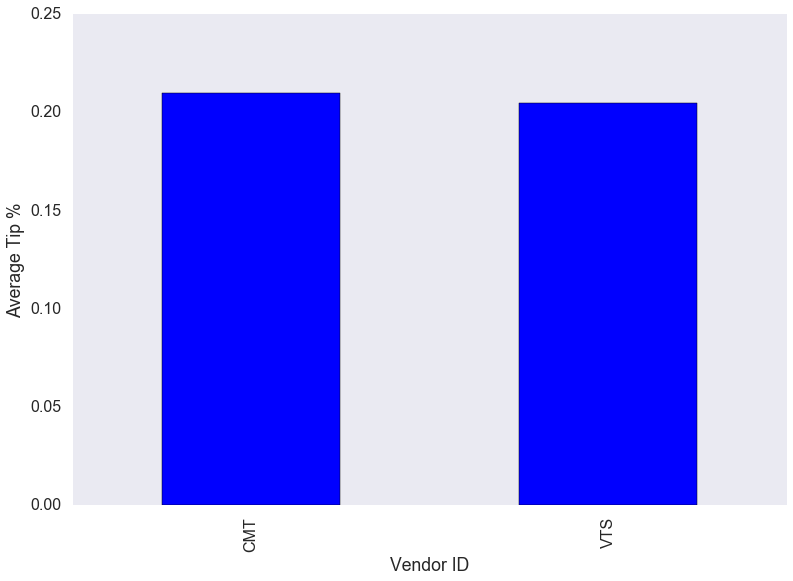

In [23]:
#Calculate average tip % for each vendor
tips_above_zero = merged2013dffull[merged2013dffull.tip_amount > 0]
vendor_tips= tips_above_zero.groupby(['vendor_id'])['tip_amount_normalized'].mean()
ax = vendor_tips.plot(kind='bar', x='vendor_id', y='tip_amount_normalized')
ax.set_xlabel("Vendor ID")
ax.set_ylabel("Average Tip %")
print vendor_tips
plt.savefig('images/vendor_tips')

# #add text values on top of the bars
# bars = ax.patches

# for bar in bars:
#     height = bar.get_height()
#     ax.text(bar.get_x() + bar.get_width()/2, height + 200, height, ha='center', va='bottom', fontsize=15)
# plt.savefig('images/vendor_tips')

While there is a 0.5% difference between the two vendors, the difference is not large. Let's look at the number of trips made by each vendor software. 

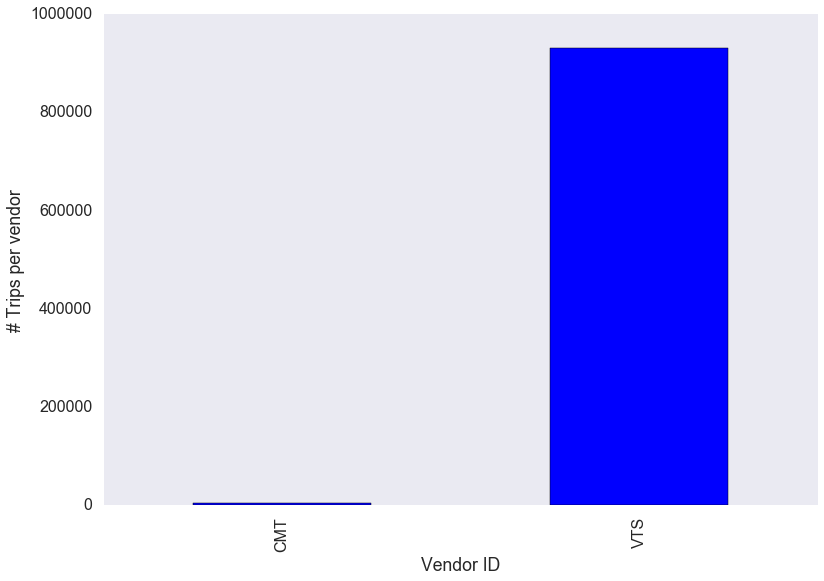

In [24]:
#Calculate number of trips made by each vendor
vendor_fares = merged2013dffull.groupby(['vendor_id'])['medallion'].count()
ax = vendor_fares.plot(kind='bar', x='vendor_id', y='medallion')
ax.set_xlabel("Vendor ID")
ax.set_ylabel("# Trips per vendor")

In [25]:
#How many trips use CMT vs. VTS?
vendor_fares

vendor_id
CMT      3220
VTS    930558
Name: medallion, dtype: int64

Less than .3% of trips use CMT software, so we can remove these trips and only consider VTS software for consistency in our data.

In [26]:
#remove CMT, because it calculates tipping data differently and may skew our results
merged2013dffull = merged2013dffull[merged2013dffull.vendor_id == 'VTS']

In [27]:
# So what is the tip distribution like?
merged2013df.tip_amount_normalized.describe()

count    501799.000000
mean          0.200136
std           0.111903
min           0.000000
25%           0.166667
50%           0.200000
75%           0.228571
max          29.500000
Name: tip_amount_normalized, dtype: float64

For those that tip, what percentage of the total fare cost do they tip?

In [28]:
avg_tip_percent = merged2013df[merged2013df.tip_amount_normalized > 0].tip_amount_normalized.mean()
avg_tip_percent

0.2065400677167449

And what percentage of people actually tip?

In [29]:
float(len(merged2013df[merged2013df.tip_amount > 0])) / float(len(merged2013df.tip_amount))

0.9689935611669214

In [30]:
merged2013df.describe()

,rate_code,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,tip_amount_normalized,secs_since_midnight,hours_since_midnight
count,501799,501799.000000,501799.000000,501799.000000,501799.000000,501799.000000,501799.000000,501799.000000,501799.000000,501799.000000,501799.0,501799.000000,501799.000000,501799.000000,501799.000000,501799.000000,501799.000000
mean,1,2.122485,693.876827,2.685985,-73.978420,40.752416,-73.977501,40.752041,11.309331,0.333739,0.5,2.190376,0.195864,14.529311,0.200136,49792.535581,13.340160
std,0,1.725740,426.215565,2.425341,0.025175,0.022708,0.024551,0.025721,6.866730,0.376991,0.0,1.693832,0.953820,8.768058,0.111903,22810.647432,6.334577
min,1,1.000000,47.000000,0.010000,-74.024818,40.650448,-74.024963,40.650063,2.500000,0.000000,0.5,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000
25%,1,1.000000,360.000000,1.150000,-73.992752,40.738079,-73.992088,40.737267,6.500000,0.000000,0.5,1.100000,0.000000,8.900000,0.166667,32580.000000,9.000000
50%,1,1.000000,600.000000,1.880000,-73.982292,40.754150,-73.981194,40.754150,9.000000,0.000000,0.5,1.800000,0.000000,11.900000,0.200000,51300.000000,14.000000
75%,1,3.000000,900.000000,3.225000,-73.970001,40.767288,-73.967903,40.767761,13.500000,0.500000,0.5,2.600000,0.000000,16.750000,0.228571,69540.000000,19.000000
max,1,6.000000,8460.000000,60.400000,-73.850067,40.849838,-73.850021,40.849998,107.500000,1.000000,0.5,177.000000,15.050000,184.500000,29.500000,86389.000000,23.000000


##How much cash tip goes unreported?

We can calculate the baseline number of tips that goes unreported by calculating the average credit card tip and multiplying it by the total sum of cash fares. This method is a baseline, and has some flaws, which we will expand on in the next section

In [31]:
cash_sums = cashdf['fare_amount'].sum()
cash_sums*avg_tip_percent 

872383.3184017839

In this subset of 20 days, there is an estimated $872,383 worth of tips that goes unreported. Imagine if we calculated unreported cash tips on the entire dataset!

## Initial Insights

Now let's look at how different variables are correlated. First, we look at the total revenue per hour for the taxis, and how it changes throughout the day.

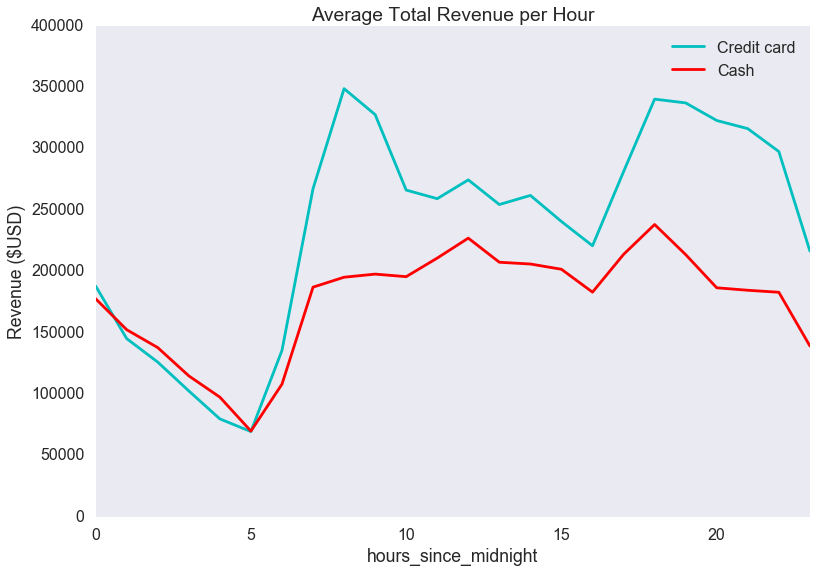

In [32]:
##Credit Card
fare_df = merged2013df.groupby(['hours_since_midnight'])['fare_amount'].sum()
ax = fare_df.plot(kind='line', x='hours_since_midnight', y='fare_amount',color='c',title='Average Total Revenue per Hour', label="Credit card")
ax.set_xlabel("Hours since Midnight")
ax.set_ylabel("Revenue ($USD)")
ax.set_ylim(0,400000)

##cash
cashdf.head()
fare2_df = cashdf.groupby(['hours_since_midnight'])['fare_amount'].sum()
fare2_df.plot(kind='line', x='hours_since_midnight', y='fare_amount',color='r',title='Average Total Revenue per Hour', label="Cash", ax=ax)
plt.legend()

plt.savefig('images/cash_cc_hourly.png')

The taxi companies make the most money during rush hours, which occur between 7-8am and 5-6pm. They make the least money in the middle of the night. It turns out that even in the city that never sleeps, people still use fewer taxis in the middle of the night! 

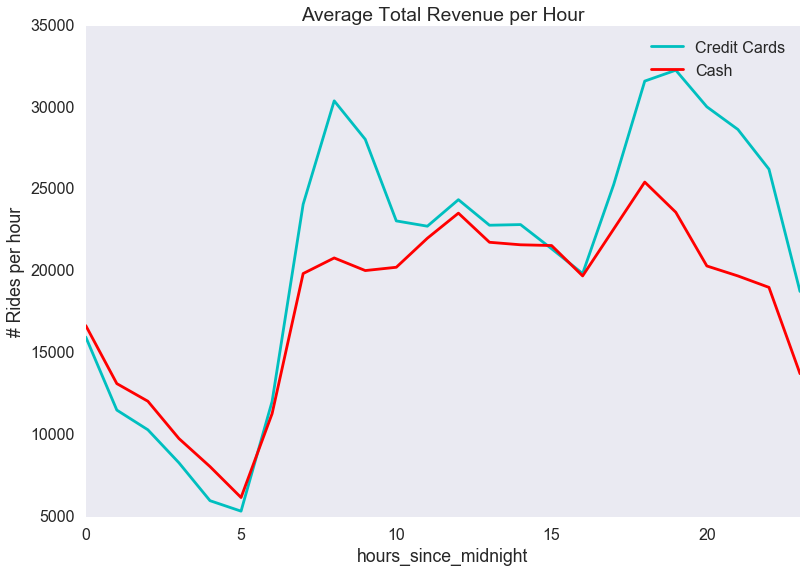

In [33]:
##Rides per hour at different times of day
rides_per_hour = merged2013df.groupby(['hours_since_midnight'])['medallion'].count()
ax = rides_per_hour.plot(kind='line', x='hours_since_midnight', y='medallion', label="Credit Cards", color='c')
ax.set_xlabel("Hours since Midnight")
ax.set_ylabel("# Rides per hour")
plt.savefig("images/rides_per_hour_vs_timeofday")

rides_per_hour2 = cashdf.groupby(['hours_since_midnight'])['medallion'].count()
rides_per_hour2.plot(kind='line', x='hours_since_midnight', y='medallion',color='r',title='Average Total Revenue per Hour', label="Cash", ax=ax)
plt.legend()

The number of rides and total revenue are closely correlated between cash and credit cards. However, it seems that credit card usage increases much more rapidly during business rush hours. Why is this? Could it be that business riders are more likely to pay with credit card?
Now let's see if average tip % changes throughout the day too!

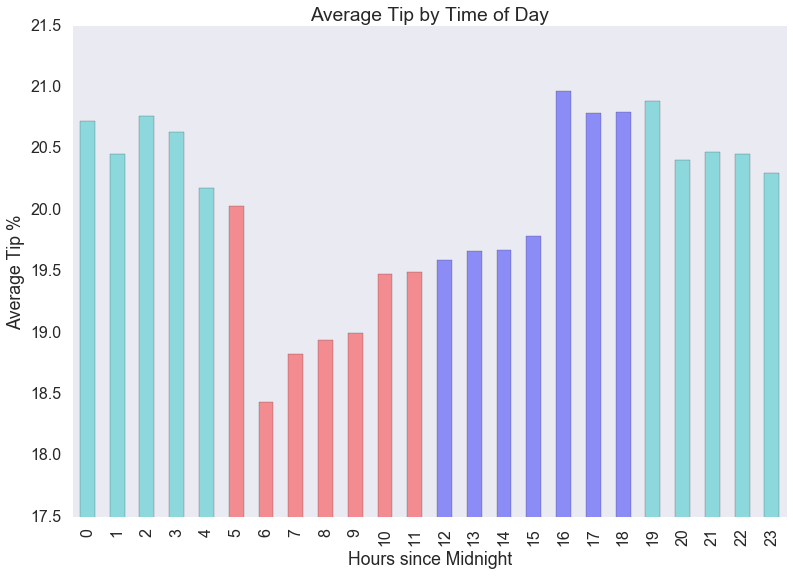

In [34]:
merged2013df['hours_since_midnight'] = np.floor(merged2013df['secs_since_midnight']/3600).apply(lambda x: int(x))
small_df = merged2013df.groupby(['hours_since_midnight'])['tip_amount_normalized'].mean().apply(lambda x: x*100)
ax = small_df.plot(kind='bar', x='hours_since_midnight', y='tip_amount_normalized', alpha=.4, title="Average Tip by Time of Day"
                   , color=['c','c','c','c','c','r','r','r','r','r','r','r','b','b','b','b','b'\
                            ,'b','b','c','c','c','c','c','c'])
plt.ylim((17.5,21.5))
ax.set_xlabel("Hours since Midnight")
ax.set_ylabel("Average Tip %")
plt.savefig("images/tip_by_hour.png")

As we can see from the graph, the largest % tips, on average, occur at night between 4-7pm. The smallest tips occur in the morning between 6am-9am. Interestingly, people tip less in the morning, and more at night! Maybe people's psychological state changes throughout the day? This would be interesting to analyze in more depth. 


In [ ]:
##Average fare per minute plotted against time of day
merged2013df['cost_per_minute'] = merged2013df['fare_amount']/(merged2013df['trip_time_in_secs']/60)

fare_per_minute = merged2013df.groupby(['hours_since_midnight'])['cost_per_minute'].mean()
ax = fare_per_minute.plot(kind='line', x='hours_since_midnight', y='cost_per_minute', color='c')
ax.set_ylim(0,1.4)
ax.set_xlabel("Hours since Midnight")
ax.set_ylabel("Cost per Minute ($US)")
plt.savefig("images/cost_per_minute_vs_timeofday")

Despite having the fewest rides, lowest revenue, and smallest average tip percentage, the morning time has the highest cost per minute for a rider.

Now let's look at a histogram of tipper tendencies. What is the most common range for tips?

In [ ]:
#remove those with extremely high tips
low_tips_df = merged2013df[merged2013df['tip_amount_normalized'] < .5]
low_tips = low_tips_df['tip_amount_normalized']
ax = low_tips.plot(kind='hist', alpha=0.5, bins=8, color='c')
ax.set_xlim(0,0.5)

As we would expect, most passengers tip between 20%-25%. Let's dive into smaller bins to see if we can extract more detail. 

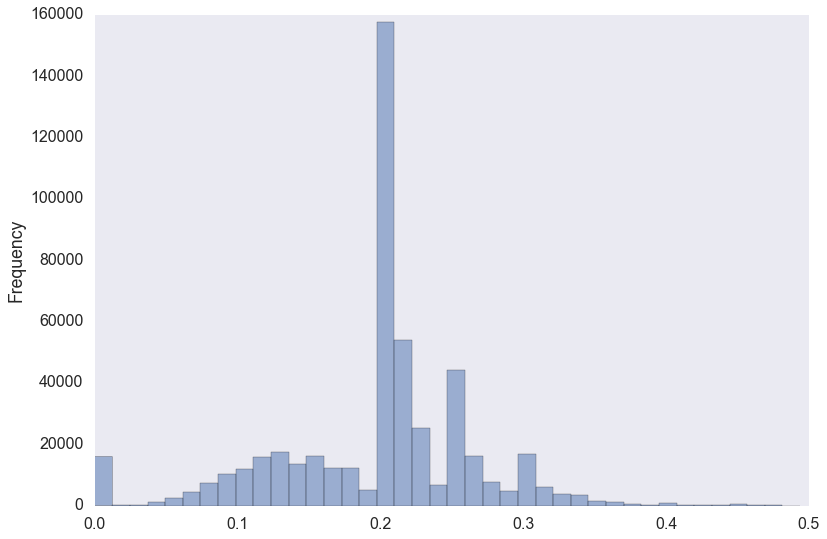

In [37]:
low_tips = low_tips_df['tip_amount_normalized']
low_tips.plot(kind='hist', alpha=0.5, bins=40)

Breaking down the histogram into greater detail, we see peaks at 0%, 20%, 25% and 30%- the default tip options on the credit card readers in cabs! This means our baseline for predicting cash tips may be less accurate, because cash tips don't have these default tip options. The histogram for cash tips would likely be more evenly distributed, and the peaks would not be as high. 

##Popular Locations

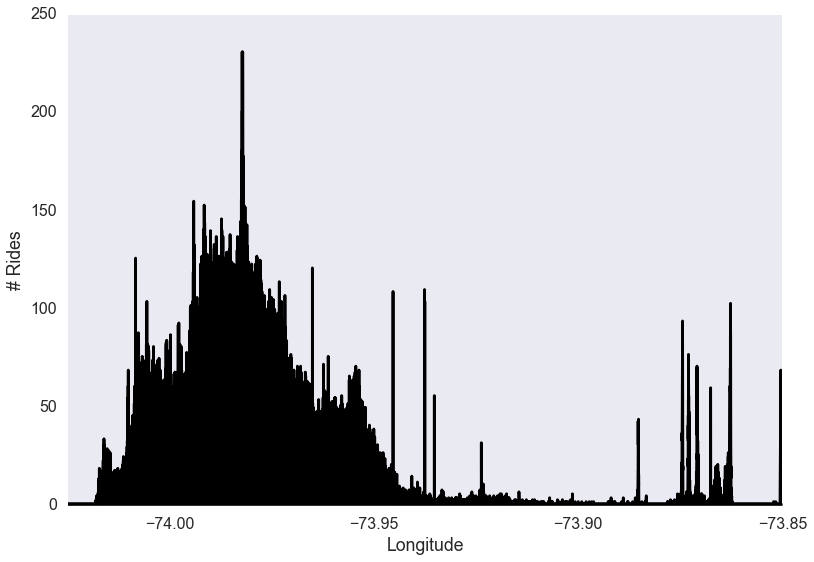

In [38]:
##Number of rides from different longitudes
longitude_frequency = merged2013df.groupby(['pickup_longitude'])['medallion'].count()
ax = longitude_frequency.plot(kind='area', x='pickup_longitude', y='medallion',colormap='cubehelix')
ax.set_xlabel("Longitude")
ax.set_ylabel("# Rides")
plt.savefig("images/rides_per_hour_vs_longitude")

In [39]:
longitude_frequency.sort(ascending=False,inplace=True)
longitude_frequency.head()

/Users/stefan/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  if __name__ == '__main__':


pickup_longitude
-73.982079    231
-73.982224    231
-73.982063    212
-73.982117    204
-73.982185    201
Name: medallion, dtype: int64

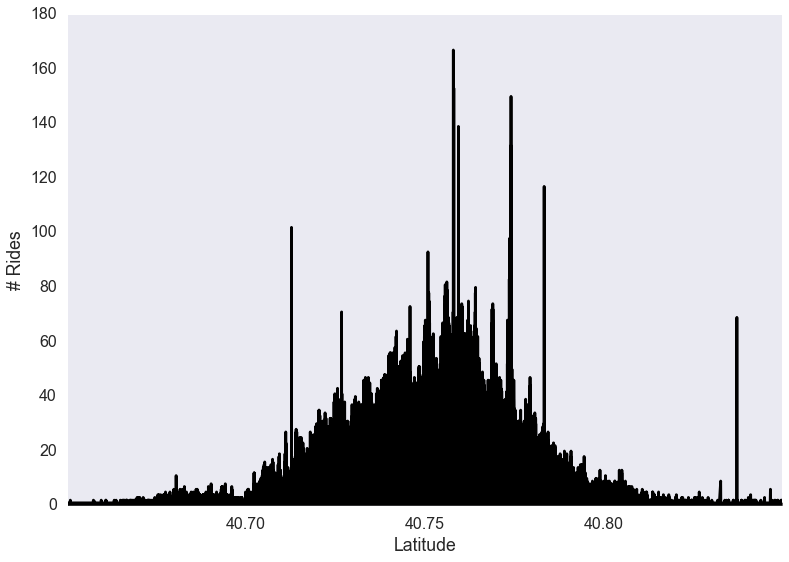

In [40]:
## Number of rides from different latitudes
latitude_frequency = merged2013df.groupby(['pickup_latitude'])['medallion'].count()
ax = latitude_frequency.plot(kind='area', x='pickup_latitude', y='medallion',colormap='cubehelix')
ax.set_xlabel("Latitude")
ax.set_ylabel("# Rides")
plt.savefig("images/rides_per_hour_vs_latitude")

In [41]:
latitude_frequency.sort(ascending=False,inplace=True)
latitude_frequency.head()

/Users/stefan/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  if __name__ == '__main__':


pickup_latitude
40.758011    167
40.758148    153
40.774117    150
40.759426    139
40.774101    132
Name: medallion, dtype: int64

# Part 1: Initial Visualizations

Let's get a sense of the data we're working with. Using Matplotlib's Basemap, we can see the pickup locations for our data subset. *(Warning: this takes about 5 minutes to run)*

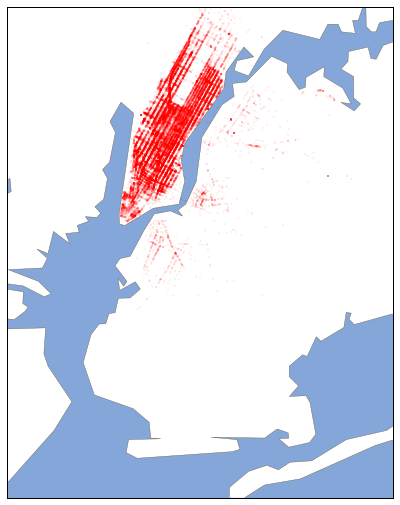

In [103]:
m = Basemap(projection='merc',llcrnrlat=40.55,urcrnrlat=40.82,\
            llcrnrlon=-74.1, urcrnrlon=-73.82, lat_ts=40.5,resolution='h')
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white', lake_color='#85A6D9')

#m.scatter(merged2013df.pickup_longitude.values, merged2013df.pickup_latitude.values, alpha = 0.006, latlon=True, zorder=10)
for i in range(50000):
    m.plot(merged2013df.pickup_longitude.values[i], merged2013df.pickup_latitude.values[i],'ro',latlon=True,ms=1,alpha=.3)

plt.savefig('images/pickup_init.png')
plt.show()

Next let's create a visualization for a single cab driver to see their pickup and 

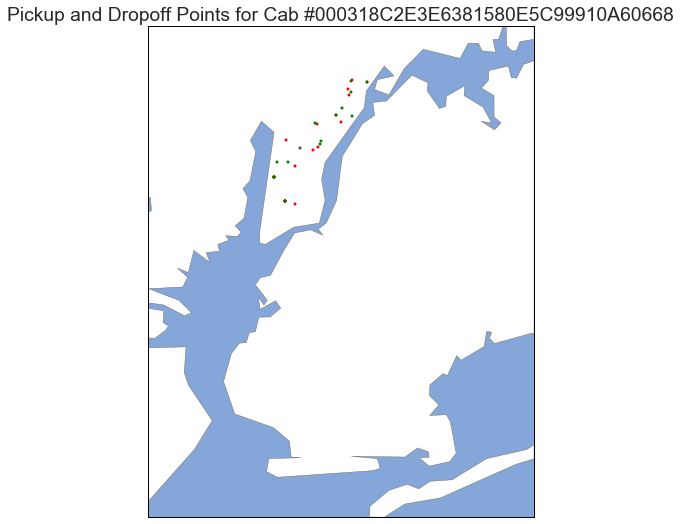

In [104]:
m = Basemap(projection='merc',llcrnrlat=40.55,urcrnrlat=40.82,\
            llcrnrlon=-74.1, urcrnrlon=-73.82, lat_ts=40.5,resolution='h')
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white', lake_color='#85A6D9')

ex_cab = merged2013df[merged2013df.medallion == '000318C2E3E6381580E5C99910A60668'].reset_index(drop=True)
mx_pickup, my_pickup = list(ex_cab.pickup_longitude),list(ex_cab.pickup_latitude)
mx_dropoff, my_dropoff = list(ex_cab.dropoff_longitude),list(ex_cab.dropoff_latitude)
assert len(mx_pickup) == len(my_pickup) == len(mx_dropoff) == len(my_dropoff)

for i in range(len(mx_pickup)):
    m.plot(mx_pickup[i], my_pickup[i],'ro',latlon=True,ms=3,alpha=1)
    m.plot(mx_dropoff[i], my_dropoff[i],'go',latlon=True,ms=3,alpha=1)

plt.title("Pickup and Dropoff Points for Cab #000318C2E3E6381580E5C99910A60668")
plt.show()

Finally, we create some histograms to examine the frequency of the important columns in our dataset.

/Users/stefan/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


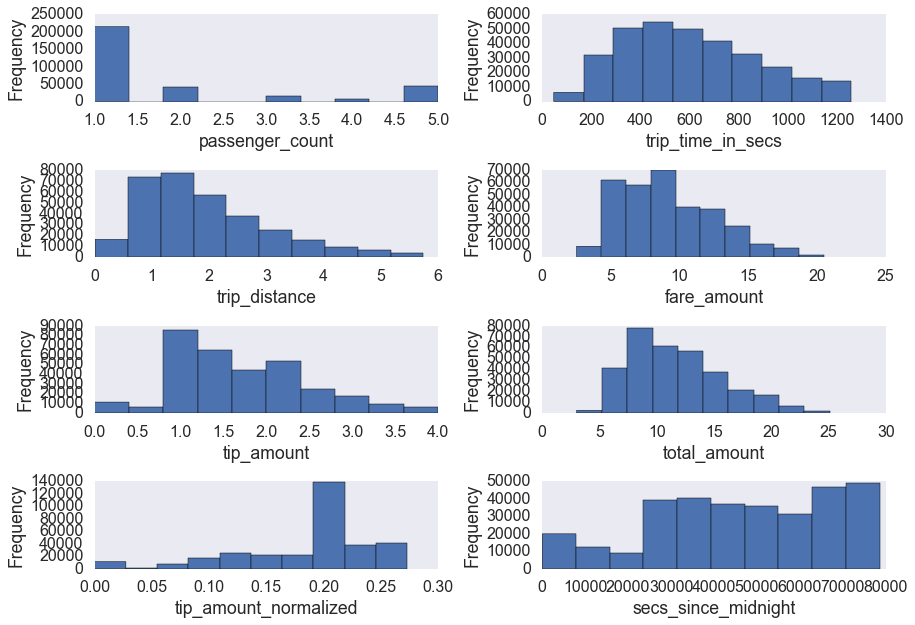

In [44]:
import itertools
hist_columns = ['passenger_count','trip_time_in_secs', 'trip_distance','fare_amount', \
                'tip_amount', 'total_amount', 'tip_amount_normalized', 'secs_since_midnight']
fig, ax_lst = plt.subplots(4, 2)
axes = itertools.chain.from_iterable(ax_lst)

quantiles = merged2013df.quantile(.90)
for column in hist_columns:
    merged2013df = merged2013df[merged2013df[column] <= quantiles[column]]

for column in hist_columns:
    ax = next(axes)
    ax.hist(merged2013df[column].values)
    #ax.set_title("Histogram")
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.legend()
    
fig.tight_layout()
plt.show()

## Part 2: The (erratic) art of tipping

We'll use `merged2013df` as our base dataset for this part.

In [45]:
merged2013df.head()

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,tip_amount_normalized,rate_code_name,secs_since_midnight,hours_since_midnight,cost_per_minute
0,F6F7D02179BE915B23EF2DB57836442D,088879B44B80CC9ED43724776C539370,VTS,1,NaN,2013-01-13 04:36:00,2013-01-13 04:46:00,5,600,3.12,-73.996933,40.720055,-73.993546,40.693043,CRD,12.0,0.5,0.5,1.75,0,14.75,0.145833,Standard Rate,16560,4,1.200000
1,BE386D8524FCD16B3727DCF0A32D9B25,4EB96EC9F3A42794DEE233EC8A2616CE,VTS,1,NaN,2013-01-13 04:37:00,2013-01-13 04:48:00,2,660,3.39,-74.000313,40.730068,-73.987373,40.768406,CRD,12.0,0.5,0.5,3.12,0,16.12,0.260000,Standard Rate,16620,4,1.090909
2,E9FF471F36A91031FE5B6D6228674089,72E0B04464AD6513F6A613AABB04E701,VTS,1,NaN,2013-01-13 04:41:00,2013-01-13 04:45:00,1,240,1.16,-73.997292,40.720982,-74.000443,40.732376,CRD,5.5,0.5,0.5,1.20,0,7.70,0.218182,Standard Rate,16860,4,1.375000
3,A5D125F5550BE7822FC6EE156E37733A,08DB3F9FCF01530D6F7E70EB88C3AE5B,VTS,1,NaN,2013-01-13 04:37:00,2013-01-13 04:47:00,5,600,2.91,-73.966843,40.756741,-73.987885,40.722713,CRD,11.0,0.5,0.5,2.00,0,14.00,0.181818,Standard Rate,16620,4,1.100000
5,34191B0F711962DA5405CF75A7D520DD,037AEA184D39DEE88D5A1026BAB7F3A0,VTS,1,NaN,2013-01-13 04:31:00,2013-01-13 04:48:00,1,1020,5.42,-73.989914,40.760544,-73.910805,40.764915,CRD,17.5,0.5,0.5,3.60,0,22.10,0.205714,Standard Rate,16260,4,1.029412


Let's start by creating a dictionary called `tipclassifiers` that contains some basic information about the tipping habits of people. We figured out the amount of tip and percentage with respect to the total fare for all riders and riders that actually give a tip. 

In [46]:
tipstats = {}
tipstats['tip'] = merged2013df[merged2013df.tip_amount > 0]
tipstats['no_tip'] = merged2013df[merged2013df.tip_amount == 0]
tipstats['tip_perc'] = float(len(merged2013df[merged2013df.tip_amount > 0])) / float(len(merged2013df))
tipstats['tip_mean'] = merged2013df.tip_amount.mean()
tipstats['pos_tip_mean'] = tipstats['tip'].tip_amount.mean()
tipstats['tip_norm_mean'] = merged2013df.tip_amount_normalized.mean()
tipstats['pos_tip_norm_mean'] = tipstats['tip'].tip_amount_normalized.mean()
print "Percentage of riders that tip: %.3f%%" % (tipstats['tip_perc'] * 100)
print "Tip amounts (all riders, riders that tip) $%.2f, $%.2f" % (tipstats['tip_mean'], tipstats['pos_tip_mean'])
print "Tip percentages (all riders, riders that tip): %.3f%%, %.3f%%" % (tipstats['tip_norm_mean'] * 100, tipstats['pos_tip_norm_mean'] * 100)

Percentage of riders that tip: 96.685%
Tip amounts (all riders, riders that tip) $1.66, $1.72
Tip percentages (all riders, riders that tip): 18.481%, 19.115%


### 2.1 Tipping based on fare amount

One interesting question we can ask is whether we can predict whether a rider will tip on a cab trip. Intuitively, we might imagine that people tend to tip based on a variety of traits. Perhaps a banker on Wall Street or someone with a relatively high income is more likely to be generous with a tip. It's plausible that riders at night are more likely to tip because they are out for entertainment or on dates, or maybe more daytime riders tip because many professionals bill the taxi fare to the company they work rather than their own credit and are therefore more likely to be generous.

In this section we'll examine what correlations exist (if any) between a rider's decision to tip and other factors related to the cab ride.

First, we'll create a regression that examines whether fare amount is correlated with the decision to tip.

In [47]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from statsmodels.formula.api import ols

**Logistic regression** is a probabilistic model that links observed binary data to a set of features.

Suppose that we have a set of binary (that is, taking the values 0 or 1) observations $Y_1,\cdots,Y_n$, and for each observation $Y_i$ we have a vector of features $X_i$. The logistic regression model assumes that there is some set of **weights**, **coefficients**, or **parameters** $\Theta$, one for each feature, so that the data were generated by flipping a weighted coin whose probability of giving a 1 is given by the following equation:

$$
P(Y_i = 1) = \sigma(\sum \Theta_i X_i),
$$

where $\sigma$ is the *sigmoid* (or logit) function

$$
\sigma(x) = \frac{e^x}{1+e^x}.
$$

When we *fit* a logistic regression model, we determine values for each $\Theta_i$ that allows the model to best fit the *training data* we have observed. Once we do this, we can use these coefficients to make predictions about data we have not yet observed.

So let's create our known observations outcomes - that is, our X and y for the fare amount and whether the riders chose to tip.

In [48]:
# X - fare amount
X = merged2013df.fare_amount.values.reshape(len(merged2013df), 1)

# y - decision to tip (binary feature)
y = merged2013df.tip_amount.apply(lambda x: 1 if x > 0 else 0).values.ravel()

# create a dataframe
logit_data = pd.DataFrame(zip(X,y))
logit_data.columns = ['fare', 'tipped']

Let's go ahead and run logistic regression on the entire data set, and see how accurate it is!


In [49]:
# instantiate a logistic regression model, and fit with X and y
logit_model = LogisticRegression()
logit_model.fit(X, y)

# check the accuracy on the training set
logit_model.score(X, y)

0.9668475622658419

54% accuracy doesn't seem great, but what's the null error rate? That is, if we predicted a rider won't tip every time, how often would we be wrong?

In [50]:
# y.mean() is the percentage that tip
y.mean()

0.9668475622658419

About 49% of riders gave no tip, which means that you could obtain 51% accuracy by always predicting "yes". So we're doing better than the positive error rate, but not in a meaningful way.

Let's quickly plot the fares against the decision to tip to visualize the findings from the our regression.

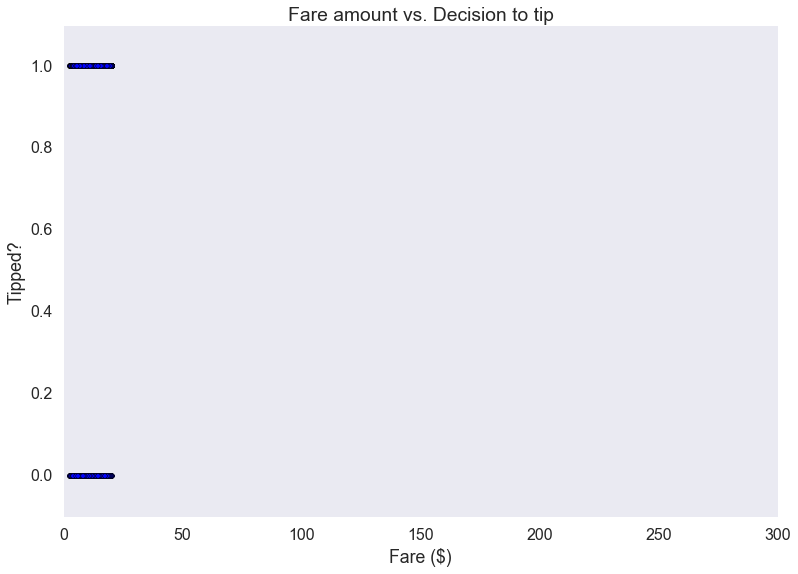

In [51]:
plt.scatter(X, y)
plt.xlim([0, 300])
plt.ylim([-0.1,1.1])
plt.title("Fare amount vs. Decision to tip")
plt.xlabel("Fare ($)")
plt.ylabel("Tipped?")
plt.show()

As the regression score suggested and the visualization demonstrates, the correlation is virtually non-existent. 

## 2.2 Finding other correlations with tip amount

We should also consider other potential factors that influence how much riders tip.

In [53]:
m = ols('tip_amount ~ fare_amount + passenger_count + trip_time_in_secs + secs_since_midnight', merged2013df).fit()
print m.summary()

                            OLS Regression Results                            
Dep. Variable:             tip_amount   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                 6.441e+04
Date:                Thu, 10 Dec 2015   Prob (F-statistic):               0.00
Time:                        21:37:34   Log-Likelihood:            -2.8092e+05
No. Observations:              321364   AIC:                         5.618e+05
Df Residuals:                  321359   BIC:                         5.619e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept               0.2103    

We can use $R^2$ as a measure of how well data fits our linear model. It represents a ratio of the explained variance to the total variance. A value of 1 means the data fits perfectly.

In [54]:
m.rsquared

0.44497973903530952

An $R^2$ value of $0.445$ and it implies that 44.5% of the variability between the two variables have been accounted for and the remaining 55.5% of the variability is still unaccounted for.

# 3.1 Predicting Unreported Tips

In the previous parts of this ipython notebook, we found that almost nobody who paid in cash had their tips recorded. This is likely because taxi drivers don't want to lose money to taxes that go along with reporting tips. We'd like to find out just how much money has gone unreported in our dataset.

Above we created a very rough baseline by taking the average tip reported for customers who paid with credit, and multiplied it by the total amount spent by customers who paid with cash in the entire dataset. The assumption behind this baseline is that people who pay in cash don't tip fundamentally differently from those who pay with credit. This seems like a fair assumption to make. It's highly unlikely that people who pay cash simply don't tip.

We'll employ a more sophisticated method to try to predict unreported tips using kNN classification.

## kNN Classification Applied to tips

kNN is a classification method that is used to predict to which class a certain data point belongs. It makes sense to think about tips in terms of classes because we think about tips fundamentally in terms of classes anyway. For example, we may think that a 10-15% tip is a reasonable tip (perhaps a bit on the low side), whereas a tip that is between 15-25% is a very good tip. Anything above that is seen as a very large tip.

The first step in this process is to create a classifier that identifies to which class a tip belongs.

In [55]:
import math
# make a copy of the df to use in machine learning classification
# credit df and cash df
crd_df = merged2013df[merged2013df.payment_type == 'CRD']

# remove outlier tips above 40%
small_crd_df = crd_df[crd_df.tip_amount_normalized <= .4]

# classify tips into buckets based on 2% intervals
small_crd_df['tip_class'] = small_crd_df.tip_amount_normalized.apply(lambda x: math.floor(x*100/2.0))

cols = ['passenger_count','trip_time_in_secs','trip_distance','fare_amount','secs_since_midnight','pickup_latitude','pickup_longitude']

# remove outliers from classifiers for plotting
small_crd_df_plot = small_crd_df[small_crd_df['trip_time_in_secs'] <= 4000]
small_crd_df_plot = small_crd_df_plot[small_crd_df_plot['trip_distance'] <= 25]
small_crd_df_plot = small_crd_df_plot[small_crd_df_plot['fare_amount'] <= 75]
small_crd_df_plot = small_crd_df_plot[small_crd_df_plot['pickup_longitude'] <= -73.5]
small_crd_df_plot = small_crd_df_plot[small_crd_df_plot['pickup_longitude'] >= -74.2]
small_crd_df_plot = small_crd_df_plot[small_crd_df_plot['pickup_latitude'] <= 41]
small_crd_df_plot = small_crd_df_plot[small_crd_df_plot['pickup_latitude'] >= 40]

In [56]:
small_crd_df[['tip_amount_normalized','tip_class']].head()

,tip_amount_normalized,tip_class
0,0.145833,7
1,0.260000,13
2,0.218182,10
3,0.181818,9
5,0.205714,10


Tips are now sorted into buckets on a 5% interval. This will hopefully allow us to predict which bucket cash tips would have fallen into had they been recorded based on the other features of the ride. Essentially, we'll find out which rides that were paid for in credit are closest to any given cash ride point (in Euclidean space) and use those to classify the credit point. This requires us the split the data into training and test sets.

Before we actually get into doing the kNN classifications, let's examine some of the different classifiers we could use. Ideally we'd like to used classifiers which are clear differentiators between tipping buckets

In [57]:
small_crd_df.head()

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,tip_amount_normalized,rate_code_name,secs_since_midnight,hours_since_midnight,cost_per_minute,tip_class
0,F6F7D02179BE915B23EF2DB57836442D,088879B44B80CC9ED43724776C539370,VTS,1,NaN,2013-01-13 04:36:00,2013-01-13 04:46:00,5,600,3.12,-73.996933,40.720055,-73.993546,40.693043,CRD,12.0,0.5,0.5,1.75,0,14.75,0.145833,Standard Rate,16560,4,1.200000,7
1,BE386D8524FCD16B3727DCF0A32D9B25,4EB96EC9F3A42794DEE233EC8A2616CE,VTS,1,NaN,2013-01-13 04:37:00,2013-01-13 04:48:00,2,660,3.39,-74.000313,40.730068,-73.987373,40.768406,CRD,12.0,0.5,0.5,3.12,0,16.12,0.260000,Standard Rate,16620,4,1.090909,13
2,E9FF471F36A91031FE5B6D6228674089,72E0B04464AD6513F6A613AABB04E701,VTS,1,NaN,2013-01-13 04:41:00,2013-01-13 04:45:00,1,240,1.16,-73.997292,40.720982,-74.000443,40.732376,CRD,5.5,0.5,0.5,1.20,0,7.70,0.218182,Standard Rate,16860,4,1.375000,10
3,A5D125F5550BE7822FC6EE156E37733A,08DB3F9FCF01530D6F7E70EB88C3AE5B,VTS,1,NaN,2013-01-13 04:37:00,2013-01-13 04:47:00,5,600,2.91,-73.966843,40.756741,-73.987885,40.722713,CRD,11.0,0.5,0.5,2.00,0,14.00,0.181818,Standard Rate,16620,4,1.100000,9
5,34191B0F711962DA5405CF75A7D520DD,037AEA184D39DEE88D5A1026BAB7F3A0,VTS,1,NaN,2013-01-13 04:31:00,2013-01-13 04:48:00,1,1020,5.42,-73.989914,40.760544,-73.910805,40.764915,CRD,17.5,0.5,0.5,3.60,0,22.10,0.205714,Standard Rate,16260,4,1.029412,10


/Users/stefan/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/stefan/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1718: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


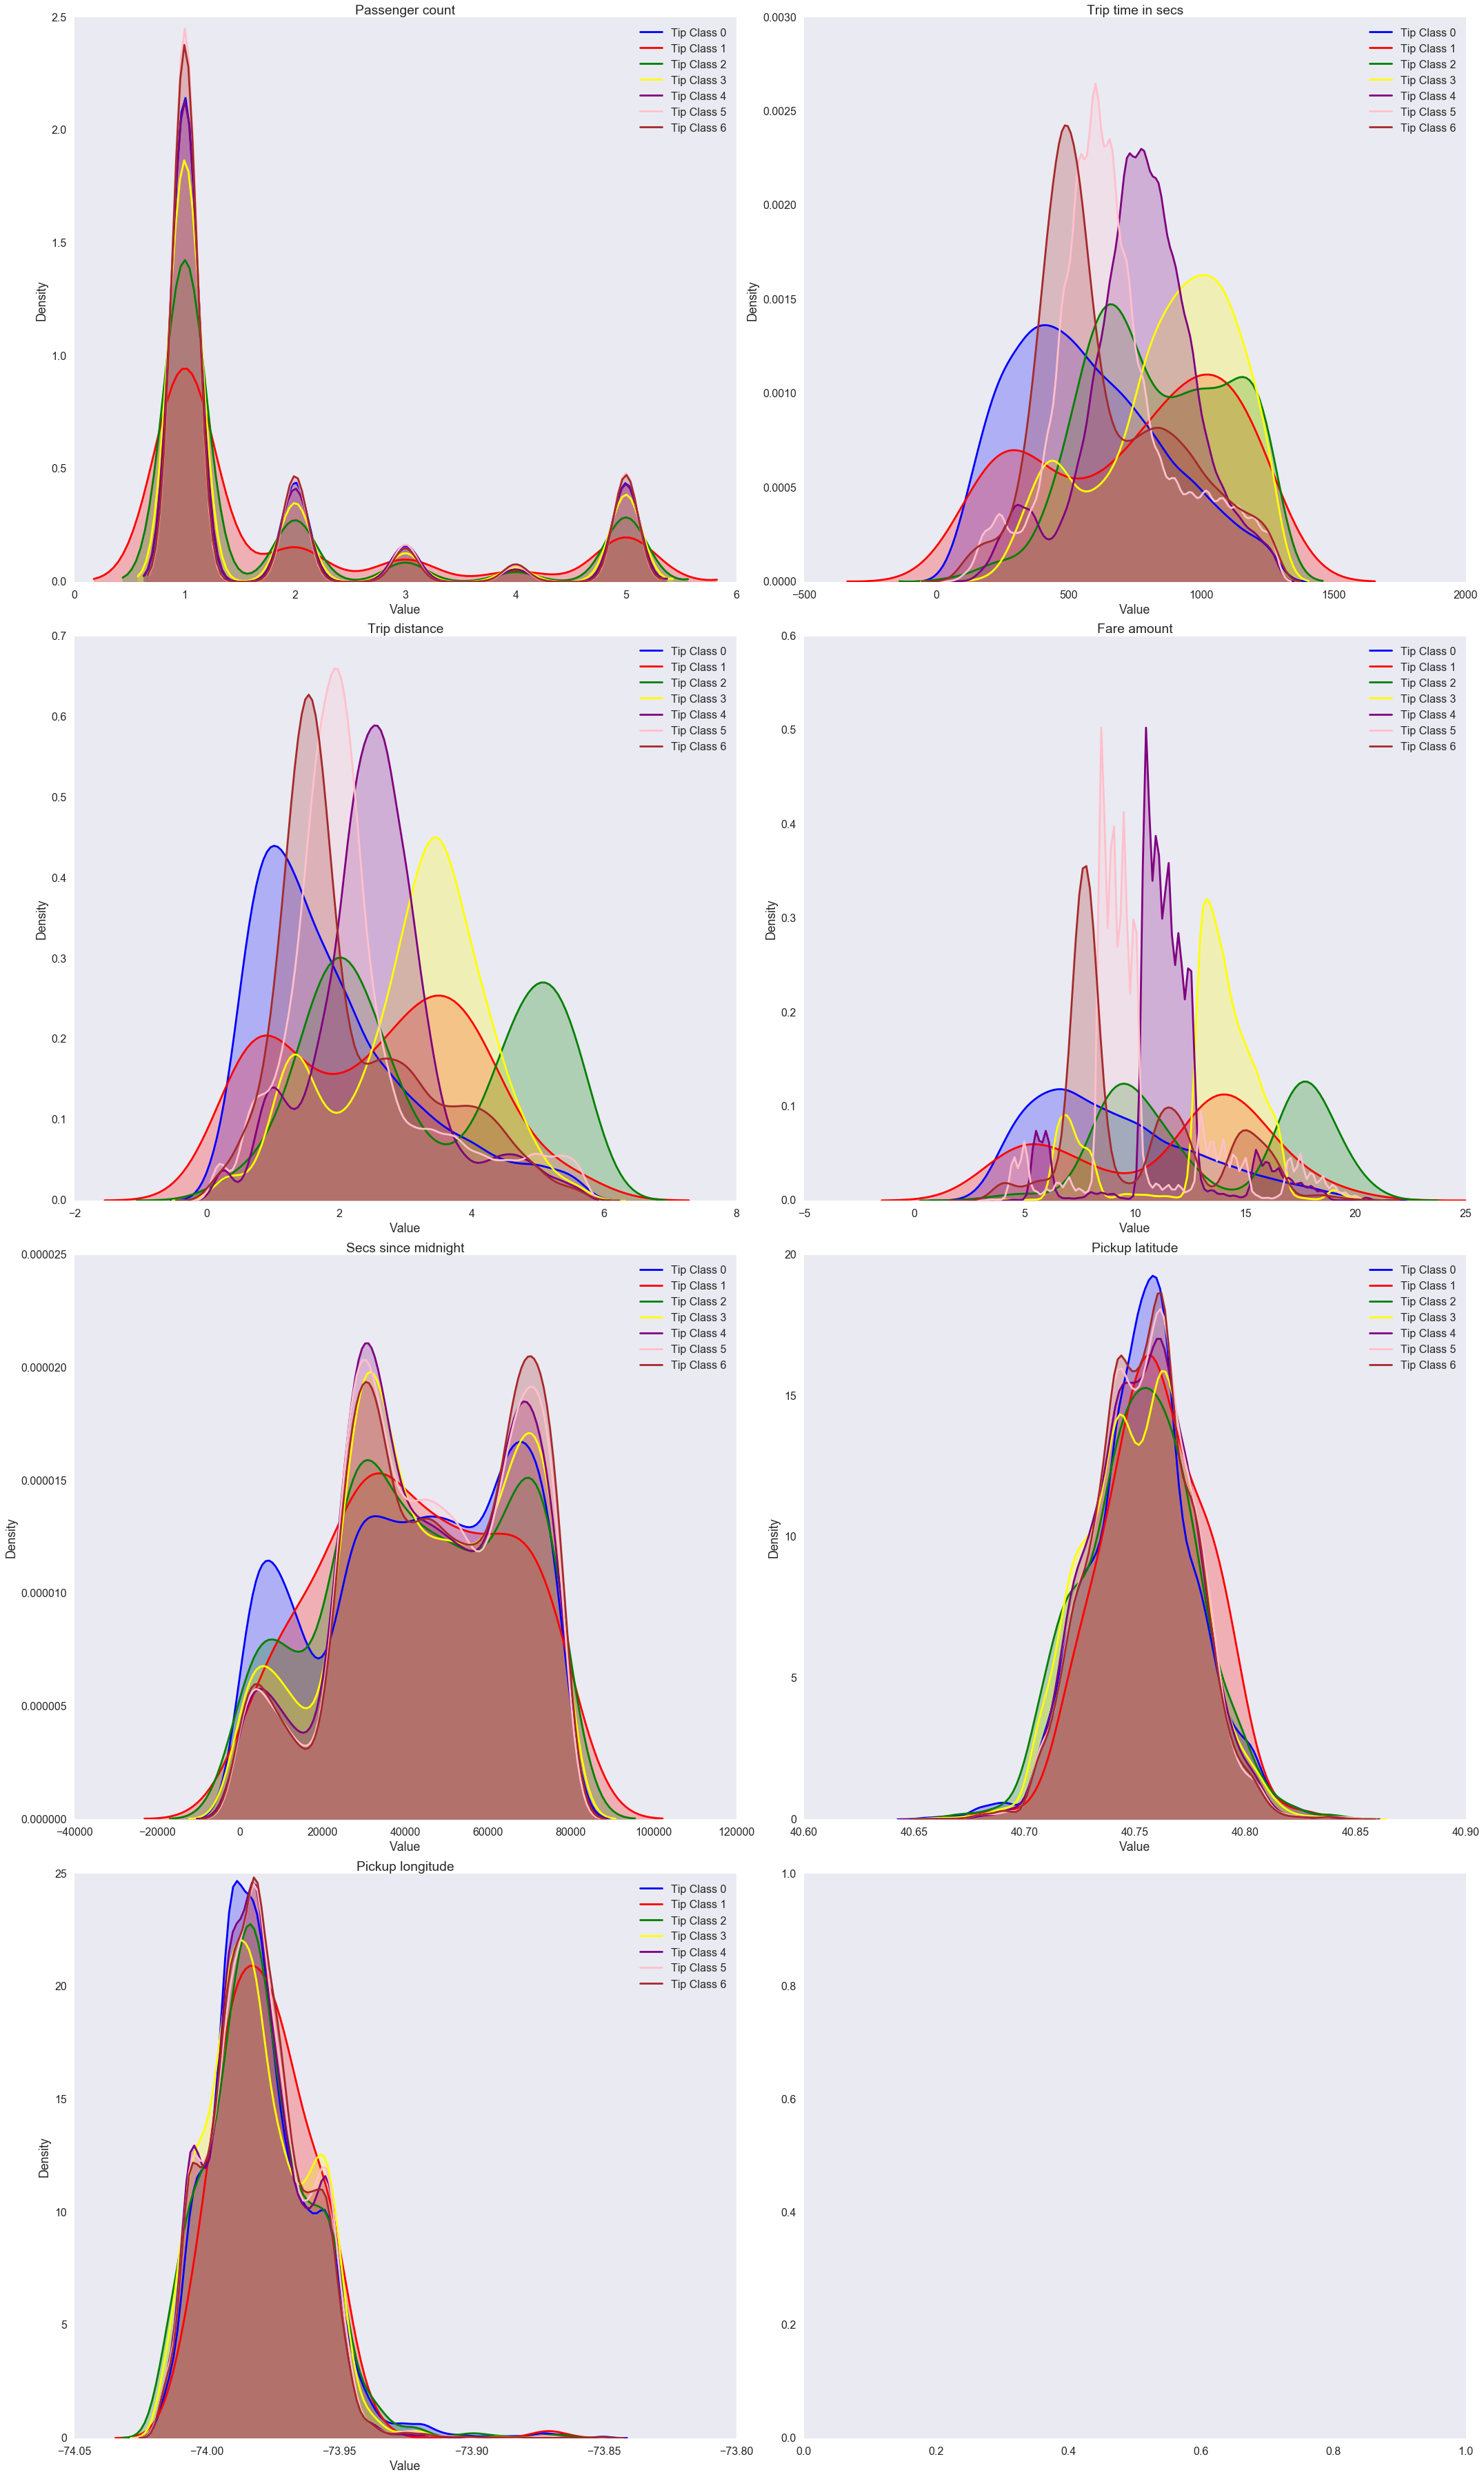

In [58]:
# create the subplots figure
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(30,50), tight_layout=True)

for a, c in zip(ax.ravel(), cols):

    # different tip classes
    tc_0 = small_crd_df_plot.loc[small_crd_df_plot['tip_class'] == 0][c]
    tc_1 = small_crd_df_plot.loc[small_crd_df_plot['tip_class'] == 1][c]
    tc_2 = small_crd_df_plot.loc[small_crd_df_plot['tip_class'] == 2][c]
    tc_3 = small_crd_df_plot.loc[small_crd_df_plot['tip_class'] == 3][c]
    tc_4 = small_crd_df_plot.loc[small_crd_df_plot['tip_class'] == 4][c]
    tc_5 = small_crd_df_plot.loc[small_crd_df_plot['tip_class'] == 5][c]
    tc_6 = small_crd_df_plot.loc[small_crd_df_plot['tip_class'] == 6][c]

    with sns.color_palette('muted'):
    # plot data
        sns.kdeplot(tc_0, color='blue', label='Tip Class 0', ax=a, shade=True)
        sns.kdeplot(tc_1, color='red', label='Tip Class 1', ax=a, shade=True)
        sns.kdeplot(tc_2, color='green', label='Tip Class 2', ax=a, shade=True)
        sns.kdeplot(tc_3, color='yellow', label='Tip Class 3', ax=a, shade=True)
        sns.kdeplot(tc_4, color='purple', label='Tip Class 4', ax=a, shade=True)
        sns.kdeplot(tc_5, color='pink', label='Tip Class 5', ax=a, shade=True)
        sns.kdeplot(tc_6, color='brown', label='Tip Class 6', ax=a, shade=True)

    # plot semantics
    a.set_title(c.replace('_',' ').capitalize())
    a.set_xlabel('Value')
    a.set_ylabel('Density')
    a.grid(False)

fig.savefig('images/KDE_kNN.png')

A first glance tells us that none of these classifiers will be great for differentiating between tip classes, since many of them are very similar. It looks as though we'll be able to classify some outlier points relativelly well based on a single classifier, but the vast majority of point will most likely be hard to predict based on the data that we have.

### kNN Classification and Regression

In [59]:
import math
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPClassifier

/Users/stefan/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:42: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/stefan/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [64]:
merged2013df['tip_class'] = merged2013df.tip_amount_normalized.apply(lambda x: math.floor(x*100/5.0))
train_df, test_df = train_test_split(merged2013df)

In [65]:
knn_train_X = train_df[['trip_time_in_secs', 'trip_distance', 'fare_amount']]
knn_train_y = train_df.tip_class
knn_test_X = test_df[['trip_time_in_secs', 'trip_distance', 'fare_amount']]
knn_test_y = test_df.tip_class

In [66]:
# Classifier
knn_clf = KNeighborsClassifier()
knn_params = dict(n_neighbors=[10,50,100], weights=['uniform','distance'])
knn_grid_search = GridSearchCV(knn_clf, param_grid=knn_params)
knn_grid_search.fit(knn_train_X, knn_train_y)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [10, 50, 100], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [67]:
# Regressor
knn_reg = KNeighborsRegressor()
knn_params = dict(n_neighbors=[10,50,100], weights=['uniform','distance'])
knn_reg_grid_search = GridSearchCV(knn_reg, param_grid=knn_params)
knn_reg_grid_search.fit(knn_train_X, knn_train_y)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [10, 50, 100], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [68]:
knn_loc_train_X = train_df[['pickup_latitude', 'pickup_longitude']]
knn_loc_train_y = train_df.tip_class
knn_loc_test_X = test_df[['pickup_latitude', 'pickup_longitude']]
knn_loc_test_Y = test_df.tip_class

In [69]:
# classifier on location
knn_loc_clf = KNeighborsClassifier()
knn_loc_grid_search = GridSearchCV(knn_loc_clf, param_grid=knn_params)
knn_loc_grid_search.fit(knn_loc_train_X, knn_loc_train_y)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [10, 50, 100], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

###  Neural Network

In [70]:
features = ['passenger_count',
            'trip_time_in_secs',
            'trip_distance',
            'pickup_longitude',
            'pickup_latitude',
            'dropoff_longitude',
            'dropoff_latitude',
            'fare_amount',
            'surcharge',
            'mta_tax',
            'tolls_amount',
            'secs_since_midnight',
            'hours_since_midnight']
nn_train_X = train_df[features]
nn_train_y = train_df.tip_class
nn_test_X = test_df[features]
nn_test_y = test_df.tip_class
scaler = StandardScaler()
scaler.fit(nn_train_X)
nn_train_X = scaler.transform(nn_train_X)
nn_test_X = scaler.transform(nn_test_X)  

In [80]:
%%time
# warning, takes over an hour to run
nn_clf = MLPClassifier(tol = 1e-3)
nn_params = dict(alpha=10.0 ** -np.arange(1, 5), hidden_layer_sizes=[(75,), (50,), (40,25)])
nn_grid_search = GridSearchCV(nn_clf, param_grid=nn_params)
nn_grid_search.fit(nn_train_X, nn_train_y)

CPU times: user 10min 8s, sys: 1min 17s, total: 11min 25s
Wall time: 10min 32s


In [81]:
print knn_grid_search.best_score_
print knn_reg_grid_search.best_score_
print knn_loc_grid_search.best_score_
print nn_grid_search.best_score_
print (train_df.tip_class.values == 4).sum() / float(train_df.tip_class.count())

0.564481398041
0.026125942258
0.5629545728
0.566078755969
0.5629545728


In [82]:
def class_to_tip_percent(tip_class):
    return max(tip_class * 5.0 / 100 - .025,0)

to_tip_perc = np.vectorize(lambda x: class_to_tip_percent(x))

baseline_predictions = np.ones_like(test_df.tip_class.values) * sp.stats.mode(test_df.tip_class.values)[0][0]
baseline_sum = (to_tip_perc(baseline_predictions) * test_df.fare_amount).sum()

nn_predictions = nn_grid_search.best_estimator_.predict(nn_test_X)
nn_sum = (to_tip_perc(nn_predictions) * test_df.fare_amount).sum()

knn_predictions = knn_grid_search.best_estimator_.predict(knn_test_X)
knn_sum = (to_tip_perc(knn_predictions) * test_df.fare_amount).sum()

knn_loc_predictions = knn_loc_grid_search.best_estimator_.predict(knn_loc_test_X)
knn_loc_sum = (to_tip_perc(knn_loc_predictions) * test_df.fare_amount).sum()

In [83]:
tip_sum = test_df.tip_amount.sum()
total = float(test_df.tip_class.count())
print "Ground truth: ", tip_sum
print "Baseline prediction: ", baseline_sum, "| Percent Error: ", (baseline_sum - tip_sum)/tip_sum
print "kNN prediction: ", knn_sum, "| Percent Error: ", (knn_sum - tip_sum)/tip_sum
print "kNN location prediction: ", knn_loc_sum, "| Percent Error: ", (knn_loc_sum - tip_sum)/tip_sum
print "NN prediction: ", nn_sum, "| Percent Error: ", (nn_sum - tip_sum)/tip_sum

Ground truth:  133835.16
Baseline prediction:  129243.7125 | Percent Error:  -0.0343067359878
kNN prediction:  129495.8875 | Percent Error:  -0.0324225151298
kNN location prediction:  129243.7125 | Percent Error:  -0.0343067359878
NN prediction:  129327.5125 | Percent Error:  -0.0336805926036


Although the Neural Network had the best score, it appears that kNN actually gets closer to the true value. We'll run both to see what their predictions are for how much cash tip goes unreported. Note that all of them are actually relatively close. Since so much of the distribution is around the 15-20% range, even though our score is low, our percent error on the total tip value is actually relatively low.

In [100]:
cash_df = merged2013dffull[merged2013dffull.payment_type == 'CSH']
cash_input = cash_df[['trip_time_in_secs', 'trip_distance', 'fare_amount']]
cash_predictions = knn_grid_search.best_estimator_.predict(cash_input)
(to_tip_perc(cash_predictions) * cash_df.fare_amount.values).sum()

741430.63749999995

In [101]:
cash_df = merged2013dffull[merged2013dffull.payment_type == 'CSH']
cash_input = cash_df[featuresures]
cash_predictions = nn_grid_search.best_estimator_.predict(cash_input)
(to_tip_perc(cash_predictions) * cash_df.fare_amount.values).sum()

736962.60000000044

While we have no ground truth to check against, it looks like around \$740,000 of cash tip goes unreported per million cab rides. From here we can extrapolate to the 375 million rides a year that take place in NYC, for a total unreported tip value of **\$129,500,000**. A quick sanity check justifies that number, since that's about \$2 per cash ride, which is a reasonable sounding tip.

##Other Visualizations & Insights

Maximum Avg. tip for a Medalion =  0.272727272727
Minimum Avg. tip for a Medalion =  0.0


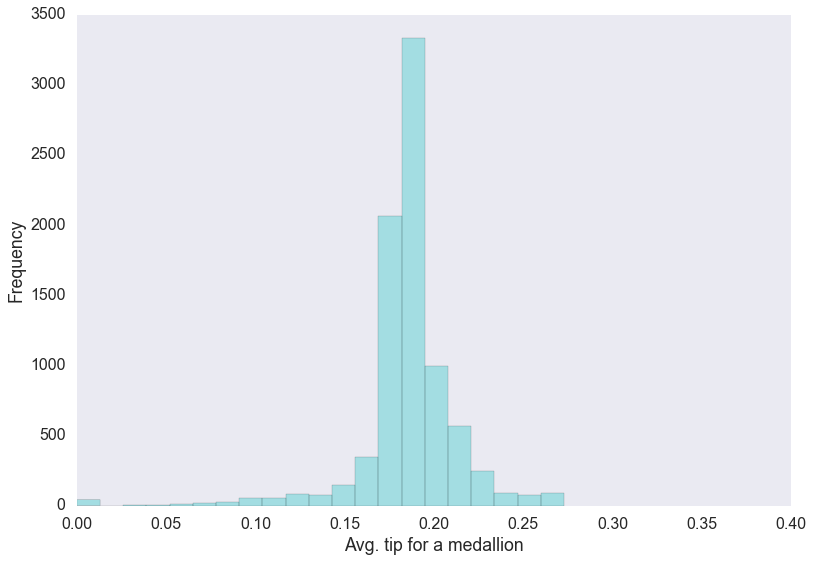

In [93]:
medallion_tips = merged2013df.groupby(['medallion'])['tip_amount_normalized'].mean()
ax = medallion_tips.plot(kind='hist', alpha=0.3, bins=21, color='c')
plt.xlim(0,.4)
ax.set_xlabel("Avg. tip for a medallion")
ax.set_ylabel("Frequency")
print "Maximum Avg. tip for a Medalion = ", medallion_tips.max()
print "Minimum Avg. tip for a Medalion = ", medallion_tips.min()

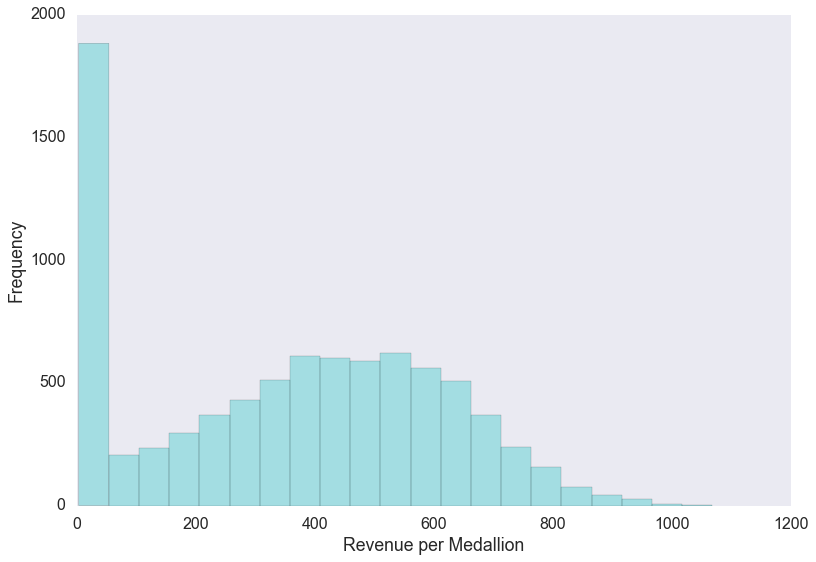

In [94]:
medallion_revenue = merged2013df.groupby(['medallion'])['fare_amount'].sum()
ax = medallion_revenue.plot(kind='hist', alpha=0.3, bins=21, color='c')
ax.set_xlabel("Revenue per Medallion")
ax.set_ylabel("Frequency")

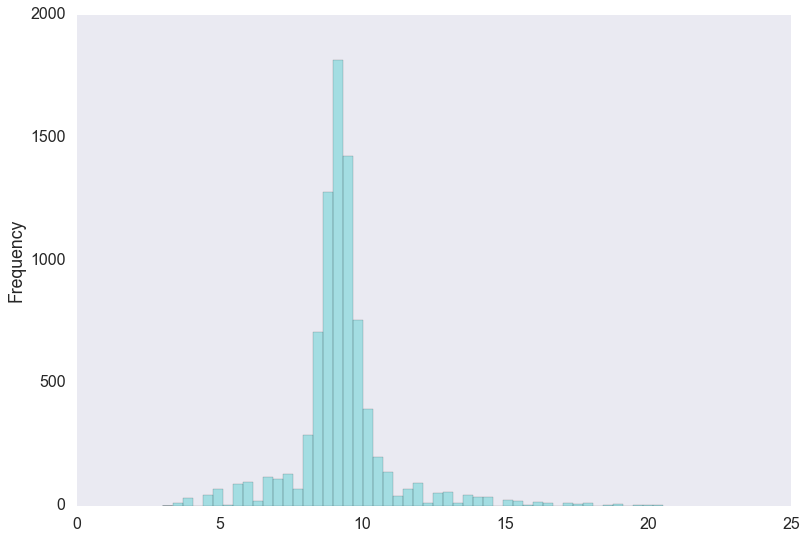

In [95]:
medallion_revenue = merged2013df.groupby(['medallion'])['fare_amount'].mean()
medallion_revenue.plot(kind='hist', alpha=0.3, bins=50, color='c')
ax.set_xlabel("Avg. fare for a medallion")
ax.set_ylabel("Frequency") 

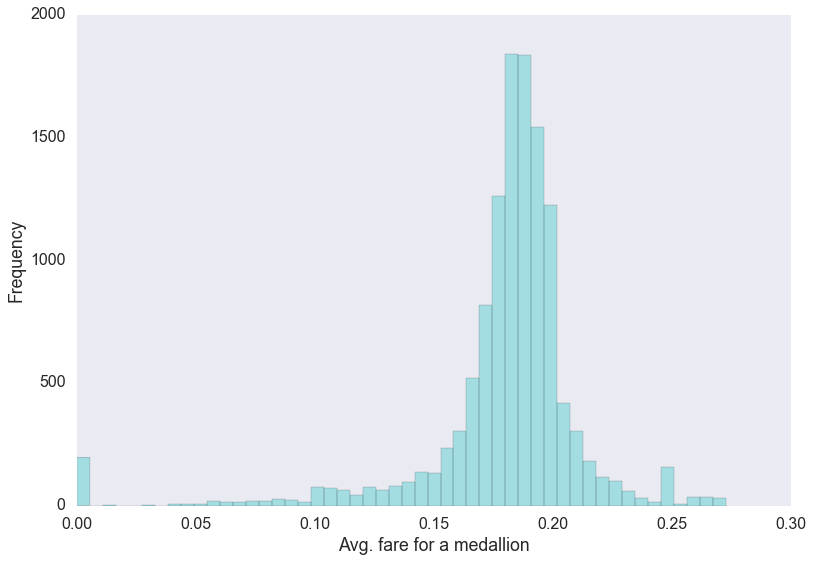

In [97]:
longitude_tip = merged2013df.groupby(['pickup_longitude'])['tip_amount_normalized'].mean()
ax = longitude_tip.plot(kind='hist', alpha=0.3, bins=50, color='c')
ax.set_xlabel("Avg. fare for a medallion")
ax.set_ylabel("Frequency")

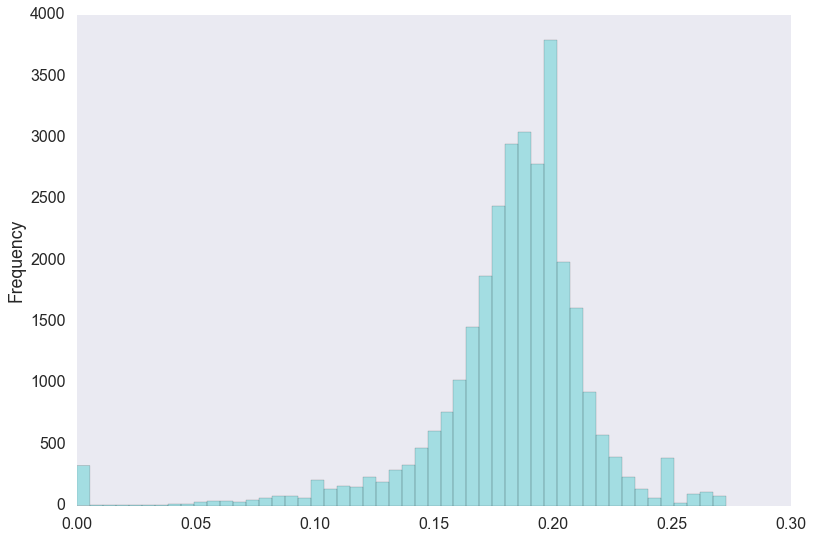

In [98]:
latitude_tip = merged2013df.groupby(['pickup_latitude'])['tip_amount_normalized'].mean()
latitude_tip.plot(kind='hist', alpha=0.3, bins=50, color='c')
ax.set_xlabel("Latitude of pickup")
ax.set_ylabel("Frequency")


# Final Analysis and Presentation

- In our initial graphs we discovered that tipping behavior and taxi revenue vary significantly depending on the time of day.  
- Using KNN and neural networks (described below), we estimated that for every million rides about \$740,000 of cash tips go unreported. And given that there were 175 million taxi rides in New York City in 2013, that would mean a whopping \$129,500,000 of revenue was never reported to the IRS that year.
- We made the initial assumption that the way riders choose to tip has a similar mentality to the way customers tip at a restaurant - essentially, that a tip acts as a rating of the service. But it turns out that 80% of cab drivers fall into the 15-20% tip range, which leads us to believe most people will simply just click the 20% button and go. And this may makes sense as a result of the taxi software, which only allow for tips of specific percentages - the most common being 20%, then 15% and 25%.
- But the fact that people's tipping behavior is highly influenced by the 20% button has important implications. Very likely, a service could increase its tip simply by presenting customers with a higher tip percentage button. It seems the convenience and convention of the 20% button makes it a popular choice, but it's very possible that people will continue to tip in the same way if the 20% button is changed to a 25% or 30% one.
- There are meaningful variations in tipping behavior depending on the time of day, which can inform cab drivers about the most profitable hours to be on the road.
- Using KNN and neural networks (described below), we estimate that for every million rides about $740,000 of cash tips go unreported. And given that there were 175 million taxi rides in New York City in 2013, that would mean a whopping \$129,500,000 of revenue was never reported to the IRS that year.
- We made the initial assumption that the way riders choose to tip has a similar mentality to the way customers tip at a restaurant - essentially, that a tip acts as a rating of the service. But it turns out that 80% of cab drivers fall into the 15-20% tip range, which leads us to believe most people will simply just click the 20% button and go. And this may makes sense as a result of the taxi software, which only allow for tips of specific percentages - the most common being 20%, then 15% and 25%.
- But the fact that people's tipping behavior is highly influenced by the 20% button has important implications. Very likely, a service could increase its tip simply by presenting customers with a higher tip percentage button. It seems the convenience and convention of the 20% button makes it a popular choice, but it's very possible that people will continue to tip in the same way if the 20% button is changed to a 25% or 30% one.